<a href="https://colab.research.google.com/github/miguelangelortizpenaranda/ortizpastorserna/blob/main/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grupo 1: Bandido de K-Brazos

Autores:

- Miguel Ángel Ortiz Peñaranda
- Miguel Pastor Beltrá
- Rubén Serna

## Introducción

El bandido de k-brazos, o k-armed bandit, supone un problema clásico de aprendizaje por refuerzo. En él, disponemos de un número K de elementos que, al activarlos, nos otorgan una recompensa determinada, desconocida a priori. Es esta recompensa la que nos interesa maximizar a lo largo del tiempo, por medio de un método que, bien explore distintos "brazos" o soluciones, bien explote la solución que en un momento dado parezca la mejor, o bien mediante un compendio de ambas prácticas.




## Preparación del entorno

Para el funcionamiento de este notebook por parte de Colab, es necesario ejecutar las líneas de código que se encuentran a continuación,
las cuales se encargan de clonar el repositorio para que el código esté disponible por parte de este notebook.


In [1]:
#!rm -r ortizpastorserna/
#!git clone https://github.com/miguelangelortizpenaranda/ortizpastorserna.git
#!cd ortizpastorserna/

A continuación añadimos al path los directorios de código fuente, tanto para ejecución en Colab como para ejecución en un IDE local.

In [2]:
#@title Importamos todas las clases y funciones
import sys

# Añadir los directorios fuentes al path de Python
sys.path.append('/content/ortizpastorserna/src/eml_k_bandit')
sys.path.append('src/eml_k_bandit')

# Verificar que se han añadido correctamente
print(sys.path)

#!ls


['/Users/miguelangel/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/jupyter_debug', '/Users/miguelangel/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Users/miguelangel/PycharmProjects/ortizpastorserna', '/Users/miguelangel/PycharmProjects/ortizpastorserna/src', '/Library/Frameworks/Python.framework/Versions/3.13/lib/python313.zip', '/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13', '/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/lib-dynload', '', '/Users/miguelangel/PycharmProjects/ortizpastorserna/.venv/lib/python3.13/site-packages', '/content/ortizpastorserna/src/eml_k_bandit', 'src/eml_k_bandit']


Realizamos los imports correspondientes a los tipos implementados de variantes del bandido de k-brazos, así como los algoritmos que se han modelado, y algunas otras librerías adicionales para representación de los resultados.

In [3]:

import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy, UCB1, Softmax
from arms import ArmNormal, ArmBinomial, Bandit
from plotting import plot_average_rewards, plot_optimal_selections

Fijamos la semilla aleatoria para asegurar la reproducibilidad de los resultados de las ejecuciones en distintos dispositivos.

In [ ]:
seed = 1234
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

## Experimento

Este código se encarga de ejecutar un número de `runs` concretos para el problema de k-armed bandit. Utilizando una lista de algoritmos y ejecutando cada algoritmo una serie de pasos, para acabar obteniendo un promedio de recompensas por ejecución, así como el porcentaje de selecciones del brazo óptimo para dichas ejecuciones.


In [4]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    """
    Ejecuta el problema del bandido de k-brazos un número de runs concretos, una serie de pasos para cada algoritmo especificado.
    :param bandit: Implementación del bandido de k-brazos a ejecutar
    :param algorithms: Listado de algoritmos a ejecutar para esa implementación del bandido
    :param steps: Número de pasos a ejecutar para cada algoritmo individual
    :param runs: Número de ejecuciones independientes que se va a hacer para todos y cada uno de los algoritmos
    :return: Promedio de recompensas y porcentaje de soluciones óptimas
    """
    optimal_arm = bandit.optimal_arm  # Se elige el brazo óptimo en base a la implementación del bandido. Necesario para calcular el porcentaje de selecciones óptimas.
    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms) # Crea una instancia nueva del bandido con la distribución que especifica la implementación parada como parámetro (normal, binomial)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                 # Modificamos optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                  optimal_selections[idx, step] += 1

    # Promediamos recompensas entre ejecuciones
    rewards /= runs

    # Calculamos el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections /= runs
    optimal_selections *= 100

    return rewards, optimal_selections


## Ejecución del experimento

A continuación, utilizando la función definida anteriormente, vamos a ejecutar el experimento del bandido. Esto se va a realizar para las dos variantes del bandido:
- Variante con distribución normal, con desviación 1.
- Variante con distribución binomial

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [5]:

# Parámetros del experimento

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
#bandit = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos de distribución binomial

print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1), UCB1(k=k, c=1), Softmax(k=k, temperature=0.5)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections = run_experiment(bandit, algorithms, steps, runs)


Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


## Visualización de los resultados

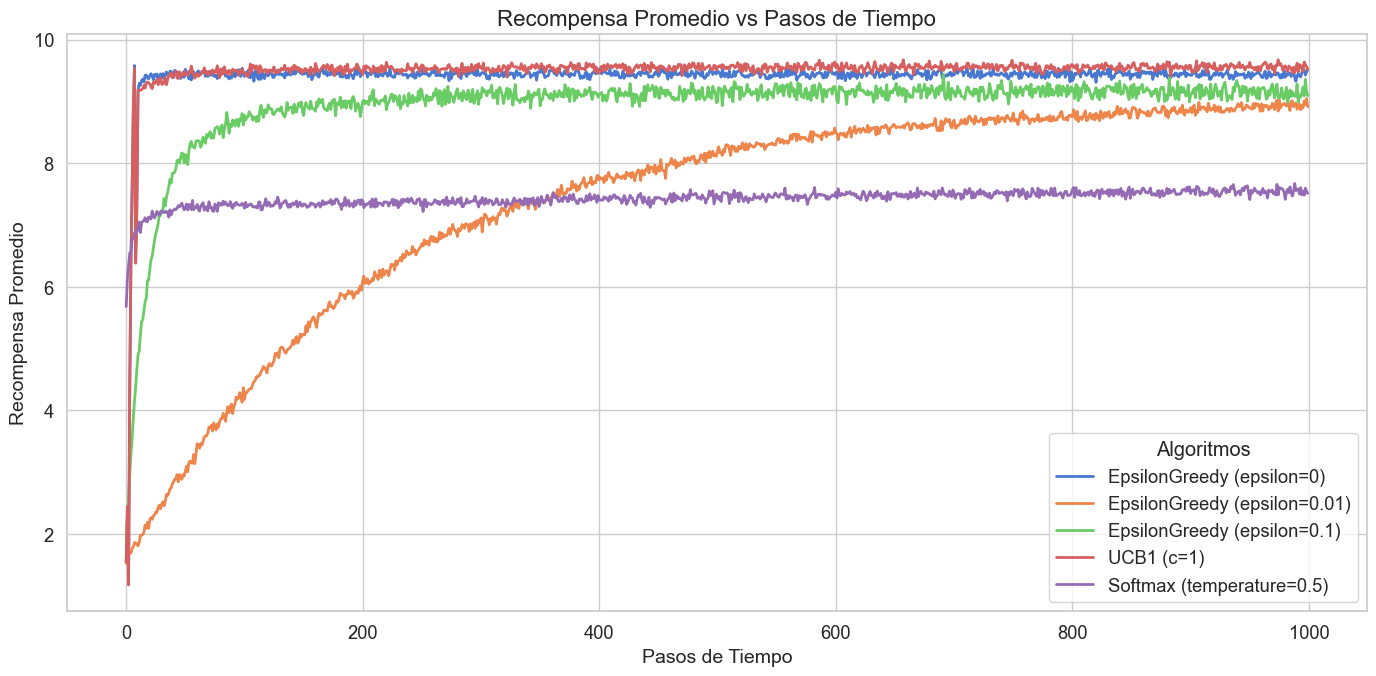

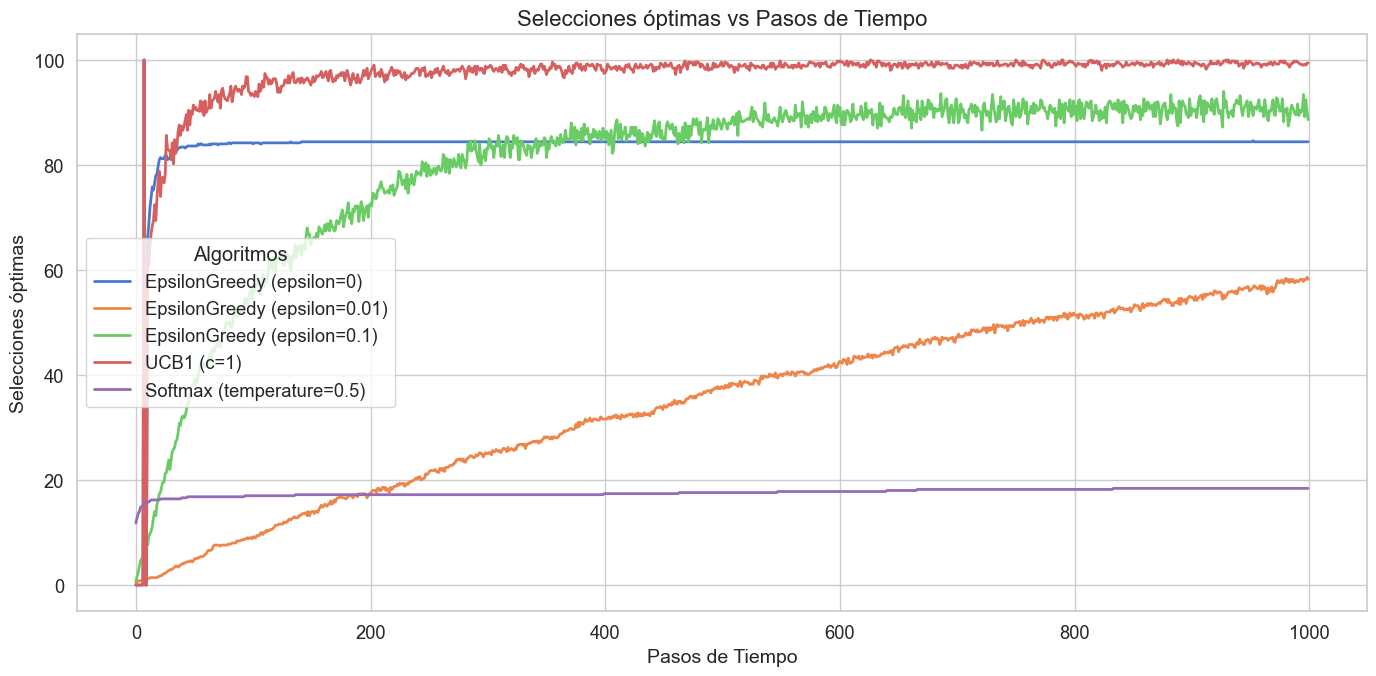

In [6]:

# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
plot_optimal_selections(steps, optimal_selections, algorithms)


### Análisis detallado de la imagen

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

---





## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

El gráfico confirma este comportamiento:
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

En conclusión, **el gráfico muestra cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀